This notebook provides simple recipes to compare `model output` and `ocean color data` in context of the [CBIOMES](https://cbiomes.org) project. It is written in [Julia](https://julialang.org) and can be used interactively via [binder](https://mybinder.org/v2/gh/gaelforget/Cbiomes2019Notebooks/master). 

<img src="figs/cbiomes-01.png" alt="Drawing" style="height: 50px;"/>

### Activate packages for later use

It is assumed that listed packages have aleary been installed using `julia`'s package manager (documentation available [here](https://docs.julialang.org/en/)). 

In [1]:
using Plots, Distributions

### Model and data wavebands

Currently, the `OC-CCI` [satellite data set](https://esa-oceancolour-cci.org) provides remotely sensed reflectance at 6 wavelengths (`wv_cci` in `nm`) while the `CBIOMES-global` [ocean model](https://cbiomes.readthedocs.io/) outputs irradiance reflectance at 13 wavelengths (`wv_drwn3` in `nm`). 

In [2]:
wv_cci=[412, 443, 490, 510, 555, 670]
wv_drwn3=[400,425,450,475,500,525,550,575,600,625,650,675,700];

### Define a test case

A vector of 13 irradiance reflectances (`Rirr`) is used to represent one space-time location in the model. Later on, we derive `Rrs0` and `Rrs` from `Rirr`. The expected results of the recipe are `ref_Rrs0` and `ref_Rrs`.

In [3]:
siz=[1,1]

Rirr=Array{Float32,3}(undef,(siz[1],siz[2],13))
Rirr[1,1,:]= 1e-3*[23.7641,26.5037,27.9743,30.4914,28.1356,
    21.9385,18.6545,13.5100,5.6338,3.9272,2.9621,2.1865,1.8015]

ref_Rrs0=Array{Float32,3}(undef,(siz[1],siz[2],13))
ref_Rrs0=1e-3*[4.1753, 4.6640, 4.9270, 5.3781, 4.9558, 3.8505
    , 3.2680, 2.3598, 0.9796, 0.6822, 0.5143, 0.3795, 0.3126]

ref_Rrs=Array{Float32,3}(undef,(siz[1],siz[2],6))
ref_Rrs=1e-3*[4.4099, 4.8533, 5.1247, 4.5137, 3.0864, 0.4064];

### Define interpolation factors

Later on, `jj` and `ww` are used to interpolate, in wavelength space, model output from `wv_drwn3` to `wv_cci`.

In [4]:
jj=Array{Int64,1}(undef,6)
ww=Array{Float64,1}(undef,6)
for ii=1:6
    tmp=wv_cci[ii].-wv_drwn3
    kk=maximum(findall(tmp.>=0))
    jj[ii]=kk
    ww[ii]=tmp[kk]/(wv_drwn3[kk+1]-wv_drwn3[kk])
end

### Convert to remotely sensed reflectance

The following recipe is from [Dutkiewicz et al 2018](https://doi.org/10.5194/bg-15-613-2018).

In [5]:
tmp=Rirr/3
Rrs0=(0.52*tmp)./(1.0 .-1.7*tmp);

### Interpolate in wavelength space

Interpolating model output from `wv_drwn3` to `wv_cci` allows for direct comparison with satellite data.

In [6]:
Rrs=Array{Float32,3}(undef,(siz[1],siz[2],6))
for vv=1:6
    tmp0=Rrs0[:,:,jj[vv]]
    tmp1=Rrs0[:,:,jj[vv]+1]
    Rrs[:,:,vv]=tmp0.*(1-ww[vv])+tmp1.*ww[vv]
end

### Verify result

Let's visualize using the `Plots.jl` package that the resulting `Rrs` matches `ref_Rrs`.

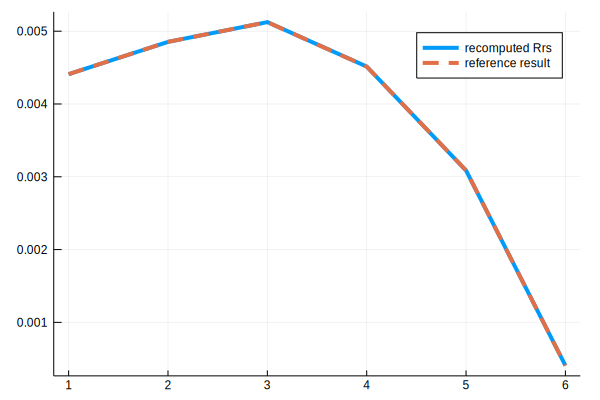

In [7]:
plot(vec(Rrs),linewidth=4,lab="recomputed Rrs")
plot!(ref_Rrs,linewidth=4,ls=:dash,lab="reference result")

### Estimate chlorophyll  from reflectances

Satellite `Chl_a` estimates provided by `OC-CCI` derive from `Rrs` using the blue/green reflectance ratio method as done with model output in the next code bloc (See [Dutkiewicz et al 2018](https://doi.org/10.5194/bg-15-613-2018) for details).

In [8]:
RRSB=max.(Rrs[:,:,2],Rrs[:,:,3]) #blue
RRSG=Rrs[:,:,5] #green
X = log10.(RRSB./RRSG) #ratio of blue to green

C=[0.3272, -2.9940, +2.7218, -1.2259, -0.5683] #OC4 algorithms (SeaWifs, CCI)
a0=C[1]; a1=C[2]; a2=C[3]; a3=C[4]; a4=C[5];
chld=exp10.(a0.+a1*X+a2*X.^2+a3*X.^3+a4*X.^4); #apply polynomial recipe

### Optical classification using reflectances

`Fuzzy logic` classifiers defined in [Moore et al 2009](https://doi.org/10.1016/j.rse.2009.07.016) and [Jackson et al 2017](http://dx.doi.org/10.1016/j.rse.2017.03.036) can be used to assign optical class memberships from an `Rrs` vector. While Moore et al define `n=8` classes using an in-situ database, Jackson et al instead define `n=14` classes using a satellite database. The latter benefits from better data coverage across all of the ecological provinces of the global ocean and is used in `OC-CCI`. 

In both cases the classifier is encoded in a mean reflectance spectra (`M[i][1:6]`) and a covariance matrix (`S[i][1:6,1:6]`) provided for each optical class (`i` in `1:n`). Class memberships are then derived by computing the squared Mahalanobis distance to each `M[i]` and passing the result to cumulative chi-squared distribution function (Equations 11 and 12 in [Moore et al 2011](https://doi.org/10.1109/36.942555)).

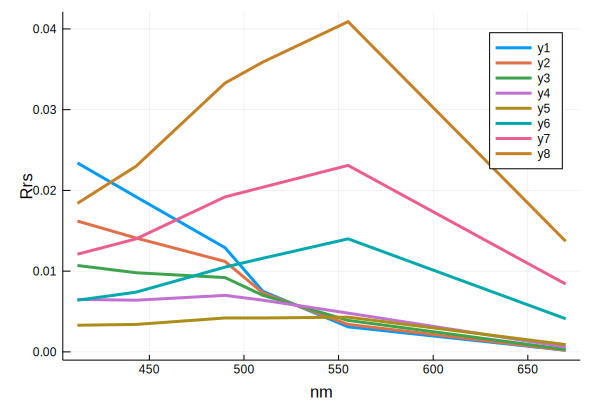

In [9]:
#Moore et al 2009 mean vectors:
M=Array{Any,1}(undef,8)
M[1]=vec([0.0234 0.0192 0.0129 0.0075 0.0031 0.0002])
M[2]=vec([0.0162 0.0141 0.0112 0.0073 0.0034 0.0002])
M[3]=vec([0.0107 0.0098 0.0092 0.0070 0.0039 0.0003])
M[4]=vec([0.0065 0.0064 0.0070 0.0064 0.0048 0.0006])
M[5]=vec([0.0033 0.0034 0.0042 0.0042 0.0043 0.0009])
M[6]=vec([0.0064 0.0074 0.0105 0.0116 0.0140 0.0041])
M[7]=vec([0.0121 0.0140 0.0192 0.0204 0.0231 0.0084])
M[8]=vec([0.0184 0.0230 0.0333 0.0359 0.0409 0.0137])

#Moore et al 2009 covariance matrices:
S=Array{Any,1}(undef,8)
S[1]=[0.00000959 0.00000556 0.00000138 -0.00000034 -0.00000024 -0.00000003; 
        0.00000556 0.00000493 0.00000193 0.00000060 0.00000023 0.00000001; 
        0.00000138 0.00000193 0.00000282 0.00000223 0.00000119 0.00000007; 
        -0.00000034 0.00000060 0.00000223 0.00000232 0.00000119 0.00000007; 
        -0.00000024 0.00000023 0.00000119 0.00000119 0.00000071 0.00000005; 
        -0.00000003 0.00000001 0.00000007 0.00000007 0.00000005 0.00000001]
S[2]=[0.00000346 0.00000186 -0.00000011 -0.00000060 -0.00000062 -0.00000005; 
        0.00000186 0.00000228 0.00000086 0.00000033 -0.00000007 0.00000003; 
        -0.00000011 0.00000086 0.00000231 0.00000221 0.00000145 0.00000023; 
        -0.00000060 0.00000033 0.00000221 0.00000266 0.00000191 0.00000034; 
        -0.00000062 -0.00000007 0.00000145 0.00000191 0.00000175 0.00000041; 
        -0.00000005 0.00000003 0.00000023 0.00000034 0.00000041 0.00000021]
S[3]=[0.00000241 0.00000144 0.00000035 -0.00000031 -0.00000063 -0.00000006; 
        0.00000144 0.00000138 0.00000076 0.00000015 -0.00000021 -0.00000001; 
        0.00000035 0.00000076 0.00000161 0.00000156 0.00000121 0.00000016; 
        -0.00000031 0.00000015 0.00000156 0.00000227 0.00000209 0.00000031; 
        -0.00000063 -0.00000021 0.00000121 0.00000209 0.00000225 0.00000037; 
        -0.00000006 -0.00000001 0.00000016 0.00000031 0.00000037 0.00000013]
S[4]=[0.00000166 0.00000091 0.00000034 -0.00000009 -0.00000080 -0.00000025; 
        0.00000091 0.00000097 0.00000071 0.00000025 -0.00000041 -0.00000015; 
        0.00000034 0.00000071 0.00000118 0.00000103 0.00000072 0.00000003; 
        -0.00000009 0.00000025 0.00000103 0.00000137 0.00000162 0.00000025; 
        -0.00000080 -0.00000041 0.00000072 0.00000162 0.00000290 0.00000065; 
        -0.00000025 -0.00000015 0.00000003 0.00000025 0.00000065 0.00000050]
S[5]=[0.00000178 0.00000132 0.00000104 0.00000081 0.00000018 -0.00000014; 
        0.00000132 0.00000127 0.00000121 0.00000099 0.00000034 -0.00000010; 
        0.00000104 0.00000121 0.00000150 0.00000142 0.00000110 0.00000013; 
        0.00000081 0.00000099 0.00000142 0.00000158 0.00000177 0.00000042; 
        0.00000018 0.00000034 0.00000110 0.00000177 0.00000351 0.00000131; 
        -0.00000014 -0.00000010 0.00000013 0.00000042 0.00000131 0.00000081]
S[6]=[0.00000715 0.00000586 0.00000409 0.00000292 0.00000005 -0.00000075; 
        0.00000586 0.00000589 0.00000520 0.00000398 0.00000027 -0.00000114; 
        0.00000409 0.00000520 0.00000634 0.00000541 0.00000188 -0.00000097; 
        0.00000292 0.00000398 0.00000541 0.00000528 0.00000392 0.00000070; 
        0.00000005 0.00000027 0.00000188 0.00000392 0.00000995 0.00000657; 
        -0.00000075 -0.00000114 -0.00000097 0.00000070 0.00000657 0.00000819]
S[7]=[0.00002625 0.00001981 0.00001058 0.00000544 -0.00000654 -0.00001122; 
        0.00001981 0.00001745 0.00001314 0.00000822 -0.00000431 -0.00001228; 
        0.00001058 0.00001314 0.00001629 0.00001226 0.00000035 -0.00001311; 
        0.00000544 0.00000822 0.00001226 0.00001170 0.00000742 -0.00000500; 
        -0.00000654 -0.00000431 0.00000035 0.00000742 0.00002241 0.00001782; 
        -0.00001122 -0.00001228 -0.00001311 -0.00000500 0.00001782 0.00003987]
S[8]=[0.00001186 0.00001134 0.00001139 0.00000919 0.00000395 -0.00000186; 
        0.00001134 0.00001484 0.00002034 0.00001907 0.00001531 0.00000087; 
        0.00001139 0.00002034 0.00003467 0.00003546 0.00003555 0.00000708; 
        0.00000919 0.00001907 0.00003546 0.00003907 0.00004604 0.00001733; 
        0.00000395 0.00001531 0.00003555 0.00004604 0.00007306 0.00004953; 
        -0.00000186 0.00000087 0.00000708 0.00001733 0.00004953 0.00006542];

Moore17=Dict("M" => M, "S" => S, "Sinv" => inv.(S))
plot(wv_cci,M,w=3); xlabel!("nm"); ylabel!("Rrs")

**Compute class memberships:**

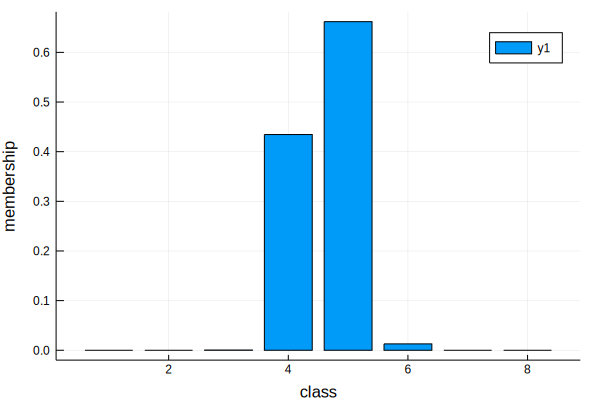

In [10]:
function fcm(M,Sinv,Rrs)
    f=Array{Any,1}(undef,length(M))
    for ii=1:length(M)
        X=vec(Rrs)-M[ii]
        Z=transpose(X)*Sinv[ii]*X
        f[ii]=ccdf(Chisq(6),Z)
    end
    f
end

Moore17["Membership"]=fcm(Moore17["M"],Moore17["Sinv"],Rrs)
bar(Moore17["Membership"]); xlabel!("class"); ylabel!("membership")